In [8]:
import numpy as np
import signal

d=1
Nr = 10
theta = np.pi/2
## Steering vector
s = [np.exp(-2j*np.pi*d*np.arange(Nr)*np.sin(theta))]

s

[array([1.+0.00000000e+00j, 1.+2.44929360e-16j, 1.+4.89858720e-16j,
        1.+7.34788079e-16j, 1.+9.79717439e-16j, 1.+1.22464680e-15j,
        1.+1.46957616e-15j, 1.+1.71450552e-15j, 1.+1.95943488e-15j,
        1.+2.20436424e-15j])]

In [10]:
##Received Signal
import numpy as np
import matplotlib.pyplot as plt

sample_rate = 1e6
N = 10000 # number of samples to simulate

#Create a tone to act as the transmitter signal
t = np.arange(N)/sample_rate #time vector
f_tone = 0.02e6
tx = np.exp(2j*np.pi*f_tone*t)

d = 0.5 #half wavelength spacing
Nr = 3
theta_degrees  = 20 # direction of arrival
theta = theta_degrees / 180 *np.pi #radians conversion
s = np.exp(-2j*np.pi * d * np.arange(Nr)*np.sin(theta)) # Steering vector
print(s) # 3D element long
#Making s a column vector
s = s.reshape(-1,1)
print(s.shape) #3x1

#Making TX a row vector
tx = tx.reshape(1,-1)
print(tx.shape)

#Simulate the received signal X through a matrix multiply
X = s@ tx
print(X.shape) #3 x 10000 X is now going to be a 2D array, 1D is time and 1D is the spatial dimension

[ 1.        +0.j          0.47618256-0.87934645j -0.54650034-0.83745888j]
(3, 1)
(1, 10000)
(3, 10000)


In [11]:
import numpy as np
#theta is the direction of interest, in radians, and X is our received signal

def w_mvdr(theta,r):
    # steering vector in the desired direciton theta
    s = np.exp(-2j* np.pi * d * np.arange(Nr) * np.sin(theta)) 
    
    #make into a column vector (size 3x1)
    s= s.reshape(-1,1)
    
    #Calculate the covariance matrix. Gives a Nr x Nr covariance matrix of the sampels
    R = (X @ X.conj().T)/X.shape[1] 

    #3x3. pseudo-inverse tends to work better/faster than a true inverse
    Rinv = np.linalg.pinv(R)

    #MVDR/Capon equation, numerator is 3x3 * 3x1, denominator is (1x3 * 3x3 * 3x1)
    #resulting in a 3x1 weights vector
    w = (Rinv @s)/(s.conj().T @ Rinv @ s)
    return w

In [19]:
#utilizing in the context of DOA
#1000 different thetas between -180 and 180 degrees
r = X #received signal
theta_scan = np.linspace(-1*np.pi, np.pi, 1000)

results = []
for theta_i in theta_scan:
    w = w_mvdr(theta_i,r) #3x1
    X_weighted = w.conj().T @X #apply weights
    power_dB = 10*np.log10(np.var(X_weighted)) #power in signal, in dB
    results.append(power_dB)
results -= np.max(results) #normalize

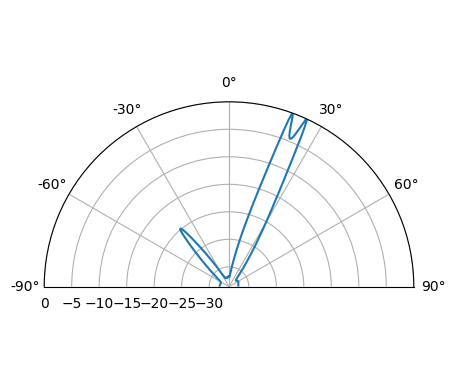

In [22]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_scan, results) # MAKE SURE TO USE RADIAN FOR POLAR
ax.set_theta_zero_location('N') # make 0 degrees point up
ax.set_theta_direction(-1) # increase clockwise
ax.set_rlabel_position(55)  # Move grid labels away from other labels
ax.set_thetamin(-90) # only show top half
ax.set_thetamax(90)
#ax.set_theta_direction(-1) # increase clockwise
ax.set_rlabel_position(55)  # Move grid labels away from other labels
plt.show()

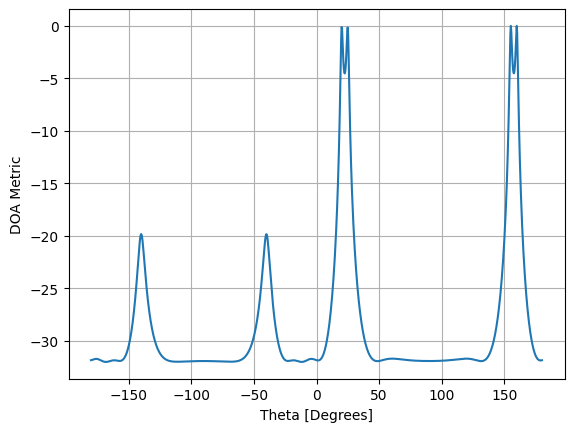

In [23]:
plt.plot(theta_scan*180/np.pi, results) #lets plot angle in degrees
plt.xlabel("Theta [Degrees]")
plt.ylabel("DOA Metric")
plt.grid()
plt.show()

In [ ]:
#MVDR example
# 8 element array receiving three signals from different angles:
## 20, 25 and 40 degrees (with the last received with much less power)

In [24]:
#Generated signal:

Nr = 8 #8 elements
theta1 = 20 / 180 * np.pi # convert to radians
theta2 = 25 / 180 * np.pi
theta3 = -40 / 180 * np.pi
s1 = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta1)).reshape(-1,1) #8x1
s2 = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta2)).reshape(-1,1)
s3 = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta3)).reshape(-1,1)

#frequencies
tone1 = np.exp(2j*np.pi*0.01e6*t).reshape(1,-1)
tone2 = np.exp(2j*np.pi*0.02e6*t).reshape(1,-1)
tone3 = np.exp(2j*np.pi*0.03e6*t).reshape(1,-1)
X = s1 @ tone1 + s2 @ tone2 + 0.1* s3 @ tone3 #note 1/10th
n = np.random.randn(Nr,N) + 1j*np.random.randn(Nr,N)
X = X+ 0.05*n #8xN